<a href="https://colab.research.google.com/github/Hing-9/popup_store/blob/main/Popup_Store_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "효과적인 팝업스토어 연계를 위한 정보 제공방안 연구" Flow Chart.
##1. Transformer를 활용하여 NER로 1차 추출
- 사용 모델 : "monologg/koelectra-base-v3-naver-ner"
- 추가적으로 AI-Hub의 구어체 데이터 사용할 것인지 생각
- 어떤 Tag까지 브랜드 명으로 볼건지 확인

##2. ChatGPT API를 활용하여 2차 추출
- NER로 추출한 후보군 및 전체 context를 입력하여 Quest-Answer로 보정
- 적절한 Prompt 구성이 중요

###====================================

- 여기까지 "브랜드명", "판매품목", "위치", "기간"을 추출
- 사람이 마지막으로 최종 결정을 내리는 것으로

###====================================

##3. 브랜드명으로 감성분석 진행
- Naver Cloud AI 참조

##4. Kakao API로 해당 위치의 정보를 추출
- 기본적으로 주변 지하철 정보, 비슷한 업종의 분포
- 공공데이터로 인구이동정보, 교통정보

##5. 오픈기간의 시계열 정보를 활용
- 날씨, 계절

#환경설정

## Library Download

In [ ]:
!pip install transformers
!pip install openai
!pip install PyKakao

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Library Import

In [ ]:
import pandas as pd
import numpy as np
import re
import ast
import json
from tqdm import tqdm
import time

from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel, pipeline
import torch
import openai

from difflib import SequenceMatcher
from datetime import datetime

from PyKakao import Local

## Google Drive Connect

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Graduation-Thesis/NER

Mounted at /content/drive
/content/drive/MyDrive/Graduation-Thesis/NER


## 데이터 Load

In [ ]:
dataset = pd.read_csv("main_df.csv", index_col=0, sep="|").dropna()
dataset

,url,content,date,ner_result,gpt_result
0,https://www.instagram.com/p/Ca899gVsqTA/,"봄향기 가득한 디즈니의 봄, 스프링블라썸 팝업스토어가자! 봄 내음이 솔솔 나는 지금...",2022-03-11,"{'brandNm': ['디즈니가', '파르나스몰에서', '디즈니랑', '파르나스몰...","{""brandNm"": ""디즈니"", ""product"": [""스프링블라썸"", ""푸"", ..."
1,https://www.instagram.com/p/Bt7bxYWA34D/,2/1~2/28 카페슈슈 in 신세계 강남 부산 용호동 JMT 마늘빵 카페슈슈가 신...,2019-02-16,"{'brandNm': ['신세계', 'JMT', '카페슈슈'], 'date': ['...","{""brandNm"": ""카페슈슈"", ""product"": [""JMT 마늘빵"", ""슈슈..."
2,https://www.instagram.com/p/B385GdSHnBh/,가로수길에 메르세데스-벤츠의 미래 모빌리티와 미래도시를 경험할 수 있는 특별한 EQ...,2019-10-23,"{'brandNm': ['벤츠의', '메르세데스-벤츠의', 'EQ', '퓨처', '...","{""brandNm"": ""메르세데스-벤츠"", ""product"": ""더 뉴 메르세데스-..."
3,https://www.instagram.com/p/CP0DnIpJFiw/,미끄러지지않는 옷걸이 마와 팝업스토어가자! 독일 발명가 바그너가 탄생시킨 70년 역...,2021-06-07,"{'brandNm': ['카톡', '마와!'], 'date': ['05.17(월)-...","{""brandNm"": ""마와"", ""product"": ""옷걸이"", ""location""..."
4,https://www.instagram.com/p/CnqgWQis0Qj/,1월 넷째 주 핫한 팝업 모음. zip WINTER CAMP 강남구 영동대로 114...,2023-01-22,"{'brandNm': ['삼성점1F', '영동대로', '더현대', 'Rola', '...","{""brandNm"":""zip WINTER CAMP, 레고, 에스더버니, Mansio..."
...,...,...,...,...,...
824,https://www.instagram.com/p/Cq9hISEvkFQ/,팝가가 미리 알려주는 업커밍 팝업스토어 KWANI & Heavenly Jelly &...,2023-04-13,"{'brandNm': ['&', 'Heavenly', '연무장17길', '헤븐리젤리...","{""brandNm"": [""KWANI"", ""Heavenly Jelly"", ""Came ..."
825,https://www.instagram.com/p/CqXXGdAPrAw/,내 안의 작은 카페 : KANU HOUSE 지하1층부터 5층 루프탑까지..카누로 가...,2023-03-31,"{'brandNm': ['루프탑까지..카누로', '카누의', 'KANU', '서울숲...","{""brandNm"": ""카누"", ""product"": ""캡슐 원두"", ""locatio..."
826,https://www.instagram.com/p/B3GRxE-HEyN/,완전체와 완전체의 콜라보! 카카오프렌즈와 나이키가 만나 홍대에 팝업스토어를 오픈했대...,2019-10-02,"{'brandNm': ['카카오프렌즈', '카카오프렌즈와', '나이키', '나이키가...","{""brandNm"": [""카카오프렌즈"", ""나이키""], ""product"": [""카카..."
827,https://www.instagram.com/p/B1nQQZhHbHQ/,"- 친환경 프리미엄 리빙브랜드, 코알라에코의 팝업스토어 오픈 소식! 키친, 욕실용품...",2019-08-26,"{'brandNm': ['코알라에코의', '에코', '코알라', '신세계'], 'd...","{""brandNm"": ""코알라에코"", ""product"": ""친환경 리빙 아이템"", ..."


# 1. 기존 Electra 모델의 사전 학습된 NER로 Tagging 해보기

- HuggingFace의 학습된 monologg/koelectra-base-v3-naver-ner 모델을 사용

In [ ]:
model_name = 'monologg/koelectra-base-v3-naver-ner'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
ner = pipeline("ner",
               model=model,
               tokenizer=tokenizer,
               ignore_labels=[]  # To show every token result
               )

In [ ]:
def get_tags(text) : 

    # 입력받은 텍스트를 선언한 pipeline(ner())으로 Token 분류
    output = ner(text)

    # 결과를 ['팝', '###업', '###스' ...]이 아닌, 어절 단위(띄어쓰기 기준)로 나오도록 변경하는 작업
    words = text.split()
    tokens_mask = []
    for word in words:
        word_tokens = tokenizer.tokenize(word)
        if not word_tokens:
            word_tokens = [tokenizer.unk_token]  # For handling the bad-encoded word
        tokens_mask.extend([1] + [0] * (len(word_tokens) - 1))

    assert len(tokens_mask) == len(output)

    word_idx = 0
    word_list = []
    candi_word_list = []
    date_list = []
    loc_list = []

    for mask, token in zip(tokens_mask, output):
        if mask == 1:
            token['word'] = words[word_idx]
            word_idx += 1

            # 개채명은 'ORG-B', 'ORG-I'등으로 나오므로, BIO표현을 제외함.
            token['entity'] = token['entity'][:3]
            
            if token['entity'] != 'O' :
                word_list.append(token)

            if token['entity'] in ['ORG', 'EVT', 'AFW'] : # 개체명 중 브랜드에 가까운 개체명을 추출 (추가고려대상 : AFW, CVL)
                if '백화점' not in token['word'] :
                    candi_word_list.append(token['word'])
                else :
                    loc_list.append(token['word'])
            
            if token['entity'] in ['DAT'] :
                date_list.append(token['word'])
            
            if token['entity'] in ['LOC'] :
                loc_list.append(token['word'])

    result = {
        # 'all_tags' : word_list,
        'brandNm' : list(set(candi_word_list)),
        'date' : date_list,
        'location' : loc_list
    }

    return result

- (참조) Naver Ner 태그 구분

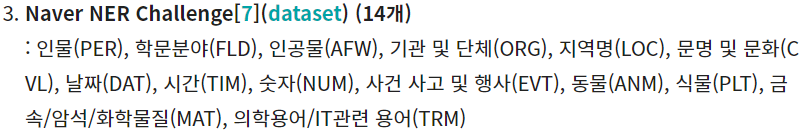

In [ ]:
dataset['ner_result'] = dataset['content'].apply(get_tags)

In [ ]:
dataset

# 2. ChatGPT API를 활용하여 NER Tagging 해보기

## Chat Response 추출

- 18$까지는 공짜라던데..

- 약 800개 돌리면 0.8$ 정도 나오는듯?

In [ ]:
openai.api_key = '' #Open AI API키 입력

### Prompt 생성

(참고) Prompt 양식
- You are the assistant who extracts words from a given pop-up store-related sentence. The words to extract are as follows. 1. Brand name, 2. Product category 3. Location, 4. Period. In addition, the output form is provided in the form of python dictionary as follows. {"brandNm": (1.), "product": (2.), "location": (3.), "date": (4.)}. If extraction is not possible, mark "null". If the result is multiple, make it into an array with "[]".'
- 당신은 정해진 팝업스토어 관련 문장에서 단어를 추출하는 어시스턴트입니다. 추출할 단어는 다음과 같습니다. 1. 브랜드명, 2. 상품 카테고리 3. 위치, 4. 기간. 또한 출력 형식은 다음과 같이 python 딕셔너리 형식으로 제공됩니다. {"brandNm": (1.), "product": (2.), "location": (3.), "date": (4.)}. 추출이 불가능한 경우 "null"로 표시합니다. 결과가 여러 개일 경우 "[]"와 함께 배열로 만듭니다

In [ ]:
def get_gpt(text) :
    
    messages = [
        {'role':'system', 'content':'You are the assistant who extracts words from a given pop-up store-related sentence. The words to extract are as follows. 1. Brand name, 2. Product category 3. Location, 4. Period. In addition, the output form is provided in the form of python dictionary as follows. {"brandNm": (1.), "product": (2.), "location": (3.), "date": (4.)}. If extraction is not possible, mark "null". If the result is multiple, make it into an array with "[]".'},
        {'role':'user', 'content':text}
    ]

    completion = openai.ChatCompletion.create(
        model = 'gpt-3.5-turbo',
        messages=messages
    )

    chat_response = completion.choices[0].message.content
    return chat_response

In [ ]:
# GPT 응답분 리셋
# dataset['gpt_result'] = ''
# dataset

,url,content,date,ner_result,gpt_result
0,https://www.instagram.com/p/Ca899gVsqTA/,"봄향기 가득한 디즈니의 봄, 스프링블라썸 팝업스토어가자! 봄 내음이 솔솔 나는 지금...",2022-03-11,"{'brandNm': ['디즈니가', '파르나스몰에서', '디즈니랑', '파르나스몰...",
1,https://www.instagram.com/p/Bt7bxYWA34D/,2/1~2/28 카페슈슈 in 신세계 강남 부산 용호동 JMT 마늘빵 카페슈슈가 신...,2019-02-16,"{'brandNm': ['신세계', 'JMT', '카페슈슈'], 'date': ['...",
2,https://www.instagram.com/p/B385GdSHnBh/,가로수길에 메르세데스-벤츠의 미래 모빌리티와 미래도시를 경험할 수 있는 특별한 EQ...,2019-10-23,"{'brandNm': ['벤츠의', '메르세데스-벤츠의', 'EQ', '퓨처', '...",
3,https://www.instagram.com/p/CP0DnIpJFiw/,미끄러지지않는 옷걸이 마와 팝업스토어가자! 독일 발명가 바그너가 탄생시킨 70년 역...,2021-06-07,"{'brandNm': ['카톡', '마와!'], 'date': ['05.17(월)-...",
4,https://www.instagram.com/p/CnqgWQis0Qj/,1월 넷째 주 핫한 팝업 모음. zip WINTER CAMP 강남구 영동대로 114...,2023-01-22,"{'brandNm': ['삼성점1F', '영동대로', '더현대', 'Rola', '...",
...,...,...,...,...,...
824,https://www.instagram.com/p/Cq9hISEvkFQ/,팝가가 미리 알려주는 업커밍 팝업스토어 KWANI & Heavenly Jelly &...,2023-04-13,"{'brandNm': ['&', 'Heavenly', '연무장17길', '헤븐리젤리...",
825,https://www.instagram.com/p/CqXXGdAPrAw/,내 안의 작은 카페 : KANU HOUSE 지하1층부터 5층 루프탑까지..카누로 가...,2023-03-31,"{'brandNm': ['루프탑까지..카누로', '카누의', 'KANU', '서울숲...",
826,https://www.instagram.com/p/B3GRxE-HEyN/,완전체와 완전체의 콜라보! 카카오프렌즈와 나이키가 만나 홍대에 팝업스토어를 오픈했대...,2019-10-02,"{'brandNm': ['카카오프렌즈', '카카오프렌즈와', '나이키', '나이키가...",
827,https://www.instagram.com/p/B1nQQZhHbHQ/,"- 친환경 프리미엄 리빙브랜드, 코알라에코의 팝업스토어 오픈 소식! 키친, 욕실용품...",2019-08-26,"{'brandNm': ['코알라에코의', '에코', '코알라', '신세계'], 'd...",


In [ ]:
# 완료되면 지우는 형식이라서 copy 사용.
dataset_gpt = dataset.copy() 

In [ ]:
# df_popup = pd.DataFrame(columns=['brandNm', 'product', 'location', 'date', 'post_date']) #처음 시작 시 사용
df_popup = pd.read_csv("popup_info_df.csv", index_col=0, sep="|").dropna() #저장된 데이터가 있을 경우 사용

#### API 호출
- Row당 최대 3번 반복하여 호출
- 매번 다른 대답이기 때문에, 전처리 시 오류처리 날 경우에는 새롭게 받음.

In [ ]:
for index, data in dataset_gpt[dataset_gpt['gpt_result']==''].iterrows() :
    print(f'Start.. Index : {index}')

    # 정상적으로 데이터를 받아 df_popup에 적재했다면, 3번 도는 for문과, Row별 도는 for문 모두를 나가야 하기 때문에 필요한 변수임.
    flag = False 

    for i in range(3) :
        print(f'Start.. Loop : {i}')
        try :
            test_text = get_gpt(data['content'])
        except :
            time.sleep(1)
            continue

        # 텍스트 전처리
        test_text.replace('\n', ' ') #Enter 제거
        test_text = re.sub('\s+', ' ', test_text) #연속 스페이스 제거

        # 딕셔너리 형태가 필요하므로 {로 시작하는 텍스트 부터 전처리 진행
        start_idx = test_text.find('{')
        if start_idx == -1 :
            continue
        else :
            test_text = test_text[start_idx:]

        # 딕셔너리 형태의 문자열이라면 json 파싱이 될 것!
        try :
            result = json.loads(test_text)
        except :
            continue

        result_arr = []
        if ((type(result['brandNm']) == list) and #value안에 여러개가 있을 때(ex. 5월 팝업 모음집)
            (result['location'] == list and result['date'] == list) and
            (len(result['brandNm']) == len(result['location']) == len(result['date']))) : #product를 제외하고는 모두 길이가 같을 경우에만 진행(GPT가 순서대로 넣었다는 가정 하에)

            tmp_dict = {}
            for i in range(len(result['brandNm'])) :
                tmp_dict = {
                    'brandNm' : result['brandNm'][i],
                    'product' : result['product'],
                    'location' : result['location'][i],
                    'date' : result['date'][i],
                }
                result_arr.apend(tmp_dict)
        else :
            result_arr.append(result)

        for each_result in result_arr :
            each_result = dict(zip(['brandNm', 'product', 'location', 'date'], list(each_result.values())))
            
            # Key값이 되는 브랜드이름이 없을 경우, Pass.
            if (not each_result['brandNm']) or (each_result['brandNm'] in ['None', 'null']) :
                continue

            each_result['post_date'] = data['date']
            each_result['origin_data_index'] = index
            df_popup = df_popup.append(each_result, ignore_index = True)
            flag = True

        if flag :
            dataset_gpt = dataset_gpt.drop(index, axis=0)
            break

    if flag :
        # 원 데이터에 결과값 저장
        dataset['gpt_result'][index] = each_result

        # csv Update
        df_popup.to_csv('popup_info_df.csv', sep='|')

In [ ]:
# csv로 저장
df_popup.to_csv('popup_info_df.csv', sep='|')
df_popup

## 데이터 정제

In [ ]:
df_popup = pd.read_csv("popup_info_df.csv", index_col=0, sep="|")
df_popup

,brandNm,product,location,date,post_date,origin_data_index
0,디즈니,스프링블라썸,삼성동 파르나스몰,03.10(목)-03.27(일),2022-03-11,0.0
1,카페슈슈,마늘빵,"['신세계강남', '부산용호동']",2/1~2/28,2019-02-16,1.0
2,메르세데스-벤츠,"['미래 모빌리티', '미래도시', 'EQ', '순수 전기차', '더 뉴 메르세데스...",강남구 도산대로 15길 35,19.10.23 ~ 20.01.19,2019-10-23,2.0
3,마와,옷걸이,롯데백화점 강남점,05.17(월)-06.13(일),2021-06-07,3.0
4,"['zip WINTER CAMP', '레고', '에스더버니', 'Mansion de...","['null', 'null', 'null', 'null', 'null']","['강남구 영동대로 114길 5 이브자리 코디센 삼성점1F', '송파구 올림픽로 3...",['01.13(금)-01.29(일) 월-토: 10:30~21:00 일요일 및 공휴일...,2023-01-22,4.0
...,...,...,...,...,...,...
842,"['KWANI', 'Heavenly Jelly', 'Came Upon']","['의류', '가방', '액세서리']",성동구 연무장17길 4,04.14(금) -04.23(일),2023-04-13,824.0
843,KANU,다양한 제품,성동구 서울숲4길 15-1,03.25(토)-05.21(일) 매일: 11:00~20:00,2023-03-31,825.0
844,"['카카오프렌즈', '나이키']","['컬렉션', '조이라이드']",홍대,9.24~10.6,2019-10-02,826.0
845,코알라에코,"['키친', '욕실용품', '핸드워시']",신세계 백화점 대구점,8/8~9/4,2019-08-26,827.0


### 복수 데이터 제거
- 하나의 Post에 여러개의 Row가 만들어질 수 없다는 가정
 - 위에서 브랜드명, 위치, 날짜의 추출된 데이터 개수가 모두 같다면 나눠서 넣어주긴 했음!
- 여러 건이면 제외한다 (추후 수동으로 분배할지도 생각)

In [ ]:
print(f'###### 전처리 전 데이터 개수 : {len(df_popup)}') #847

for index, data in df_popup.iterrows() :

    # 배열은 제외 (일단은..)
    for colNm in ['brandNm', 'location', 'date'] :
        if (data[colNm].find('[')!=-1) and (data[colNm].find(']')!=-1) :
            df_popup = df_popup.drop(index, axis=0)
            break

print(f'###### 전처리 후 데이터 개수 : {len(df_popup)}')

###### 전처리 전 데이터 개수 : 847
###### 전처리 후 데이터 개수 : 670


### date 컬럼
 - start_ymd, end_ymd date_diff로 분리 (시작일, 종료일, 기간)

In [ ]:
def extract_date(date_string) :

    date_string = re.sub('\s+', '', date_string) #연속 스페이스 제거

    match0 = re.search(r'\d{2,4}[./-](\d{1,2})[./-](\d{1,2})\D+\d{2,4}[./-](\d{1,2})[./-](\d{1,2})', date_string)
    match1 = re.search(r'\d{2,4}[./-](\d{1,2})[./-](\d{1,2})\D+(\d{1,2})[./-](\d{1,2})', date_string)
    match2 = re.search(r'(\d{1,2})[./-](\d{1,2})\D+(\d{1,2})[./-](\d{1,2})', date_string)
    match3 = re.search(r'(\d{1,2})[월](\d{1,2})[일]\D+(\d{1,2})[월](\d{1,2})[일]', date_string)
    # match4 = re.search(r'(\d{1,2})[./-](\d{1,2})[~-](\d{1,2})$', date_string)

    # print("start!! "+date_string)

    all_date_arr = []

    if match0:
        for i in range(1, 5) :
            all_date_arr.append(match0.group(i))
    elif match1:
        for i in range(1, 5) :
            all_date_arr.append(match1.group(i))
    elif match2:
        for i in range(1, 5) :
            all_date_arr.append(match2.group(i))
    elif match3:
        for i in range(1, 5) :
            all_date_arr.append(match3.group(i))
    # elif match4:
    #     all_date_arr = [match4.group(1), match4.group(2), match4.group(1), match4.group(3)]
    else: 
        # print('out~')
        return None

    # print(all_date_arr)
    start_date = all_date_arr[0].zfill(2) + all_date_arr[1].zfill(2)
    end_date = all_date_arr[2].zfill(2) + all_date_arr[3].zfill(2)

    # print([start_date, end_date])

    return [start_date, end_date]

In [ ]:
print(f'###### 전처리 전 데이터 개수 : {len(df_popup)}') #670
df_popup['start_ymd'] = ''
df_popup['end_ymd'] = ''
df_popup['date_diff'] = ''
for index, data in df_popup.iterrows() :
    mmdd_arr = extract_date(data['date'])

    if not mmdd_arr : 
        continue
    
    if int(mmdd_arr[0][:2]) > int(mmdd_arr[1][:2]) :
        start_ymd = data['post_date'][:4]+mmdd_arr[0]
        end_ymd = str(int(data['post_date'][:4])+1)+mmdd_arr[1]
    else :
        start_ymd = data['post_date'][:4]+mmdd_arr[0]
        end_ymd = data['post_date'][:4]+mmdd_arr[1]

    try :
        start_ymd_tmp = datetime.strptime(start_ymd, "%Y%m%d")
        end_ymd_tmp = datetime.strptime(end_ymd, "%Y%m%d")
        date_diff = end_ymd_tmp - start_ymd_tmp

        if date_diff.days < 0 :
            print('error : '+str(index))
            continue

        # 데이터에 결과값 저장
        df_popup['start_ymd'][index] = start_ymd
        df_popup['end_ymd'][index] = end_ymd
        df_popup['date_diff'][index] = date_diff.days
    except : 
        continue
    
print(f'###### 전처리 후 데이터 개수 : {len(df_popup[df_popup["start_ymd"]!=""])}')

###### 전처리 전 데이터 개수 : 670


<ipython-input-127-a8de0a5cdbc0>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['start_ymd'][index] = start_ymd
<ipython-input-127-a8de0a5cdbc0>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['end_ymd'][index] = end_ymd
<ipython-input-127-a8de0a5cdbc0>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['date_diff'][index] = date_diff.days


###### 전처리 후 데이터 개수 : 600


In [ ]:
# # 수기처리로 꾸역꾸역 넣기
# for index, data in df_popup[df_popup['start_ymd']==''].iterrows() :
#     print(data[['date','post_date']])
#     mmdd_arr = input("Input 'MMDD, MMDD' Here : ").split(',') # 수기처리
#     print('='*60)
    
#     if len(mmdd_arr) < 2 :
#         df_popup = df_popup.drop(index, axis=0)
#         continue
    
#     if int(mmdd_arr[0][:2]) > int(mmdd_arr[1][:2]) :
#         start_ymd = data['post_date'][:4]+mmdd_arr[0]
#         end_ymd = str(int(data['post_date'][:4])+1)+mmdd_arr[1]
#     else :
#         start_ymd = data['post_date'][:4]+mmdd_arr[0]
#         end_ymd = data['post_date'][:4]+mmdd_arr[1]

#     start_ymd_tmp = datetime.strptime(start_ymd, "%Y%m%d")
#     end_ymd_tmp = datetime.strptime(end_ymd, "%Y%m%d")
#     date_diff = end_ymd_tmp - start_ymd_tmp

#     if date_diff.days < 0 :
#         print('error : '+str(index))
    
#     # 데이터에 결과값 저장
#     df_popup['start_ymd'][index] = start_ymd
#     df_popup['end_ymd'][index] = end_ymd
#     df_popup['date_diff'][index] = date_diff.days

### 위치 컬럼
 - kakaoAPI로 검색 후 저장

In [ ]:
df_popup

,brandNm,product,location,date,post_date,origin_data_index,start_ymd,end_ymd,date_diff
0,디즈니,스프링블라썸,삼성동 파르나스몰,03.10(목)-03.27(일),2022-03-11,0.0,20220310,20220327,17
2,메르세데스-벤츠,"['미래 모빌리티', '미래도시', 'EQ', '순수 전기차', '더 뉴 메르세데스...",강남구 도산대로 15길 35,19.10.23 ~ 20.01.19,2019-10-23,2.0,20191023,20200119,88
3,마와,옷걸이,롯데백화점 강남점,05.17(월)-06.13(일),2021-06-07,3.0,20210517,20210613,27
6,딥아트먼트 스토어,"와인, 가구, 홈데코, 아트 토이",영등포 코트야드 메리어트 5층,12월 3일부터 3주간,2021-12-03,6.0,,,
8,츄파춥스,['자이언트츄파춥스'],부산 신세계사이먼 츄파춥스,2/22~2/28,2019-02-28,8.0,20190222,20190228,6
...,...,...,...,...,...,...,...,...,...
840,동명양과자점,['초코디저트'],수원 AK 플라자 백화점 B1층 식품관,2월 7일 - 2월 14일,2020-02-10,822.0,20200207,20200214,7
841,시노베 브라운치즈,"['치즈', '와플', '파니니']",부산 서면 롯데백화점,9.27 - 10.03,2019-09-30,823.0,20190927,20191003,6
843,KANU,다양한 제품,성동구 서울숲4길 15-1,03.25(토)-05.21(일) 매일: 11:00~20:00,2023-03-31,825.0,20230325,20230521,57
845,코알라에코,"['키친', '욕실용품', '핸드워시']",신세계 백화점 대구점,8/8~9/4,2019-08-26,827.0,20190808,20190904,27


In [ ]:
api_key = '' # Kakao Api Key 입력
api = Local(service_key = api_key)

In [ ]:
def find_xy(loc_text) :

    # 괄호 제거
    loc_text = re.sub(r'\([^)]*\)', '', loc_text)

    # 층 정보 제거
    text_arr = loc_text.split()
    for each in text_arr :
        if each[-1:] == '층' :
            text_arr.remove(each)

    loc_text = ' '.join(text_arr)

    for i in range(3) :

        df_result = api.search_keyword(loc_text,  dataframe=True)

        # 검색 결과가 없으면
        if len(df_result) < 1 :
            tmp_arr = loc_text.split()
            
            # 너무 짧으면 그냥 리턴
            if len(tmp_arr) < 2 :
                return pd.DataFrame(['', '', '', ''])
            
            loc_text = ' '.join(tmp_arr[:-1])
        else :
            break
        
    result = df_result.loc[0]

    if result['road_address_name'] :
        address = result['road_address_name']
    else :
        address = result['address_name']

    return [result['place_name'], address, result['x'], result['y']]

In [ ]:
# # 검색값 초기화
# df_popup['address_name'] = ''
# df_popup['address'] = ''
# df_popup['x'] = ''
# df_popup['y'] = ''

In [ ]:
# 주소 검색
for index, data in df_popup[df_popup['address']==''].iterrows() :

    try :
        result = find_xy(data['location'])[0]
        print(f'============ now start idx : {index}')
        print(result)

        # 원 데이터에 결과값 저장
        df_popup['address_name'][index] = result[0]
        df_popup['address'][index] = result[1]
        df_popup['x'][index] = result[2]
        df_popup['y'][index] = result[3]
    except :
        continue

============ now start idx : 13
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 25
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 33
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 76
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 99
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 140
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 182
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 186
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 188
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 385
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 401
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 406
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 408
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 475
0                아모레 성수
1      서울 성동구 아차산로11길 7
2    127.05918089585325
3    37.544358442027864
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 515
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 526
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 605
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 610
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 624
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 641
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 658
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 732
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 741
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 768
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

============ now start idx : 846
0    
1    
2    
3    
Name: 0, dtype: object


<ipython-input-152-4048ab6ea935>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address_name'][index] = result[0]
<ipython-input-152-4048ab6ea935>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['address'][index] = result[1]
<ipython-input-152-4048ab6ea935>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['x'][index] = result[2]
<ipython-input-152-4048ab6ea935>:13: SettingWithCopyWarning: 
A value is t

In [ ]:
con1 = (df_popup['address']!='') & (df_popup["start_ymd"]!='')
len(df_popup[con1])

573

- 아직 괜찮다고 판단. 필요할 경우 date 및 location 전처리에서 제거된 데이터를 수기로 설정해줄 필요가 있어보임.

In [ ]:
df_popup = df_popup[con1]
df_popup

<ipython-input-163-75133b7da21e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_popup = df_popup[con1]


,brandNm,product,location,date,post_date,origin_data_index,start_ymd,end_ymd,date_diff,address_name,address,x,y
0,디즈니,스프링블라썸,삼성동 파르나스몰,03.10(목)-03.27(일),2022-03-11,0.0,20220310,20220327,17,파르나스몰,서울 강남구 테헤란로 521,127.060831669861,37.5093068276361
2,메르세데스-벤츠,"['미래 모빌리티', '미래도시', 'EQ', '순수 전기차', '더 뉴 메르세데스...",강남구 도산대로 15길 35,19.10.23 ~ 20.01.19,2019-10-23,2.0,20191023,20200119,88,신사가로수길 유료주차장,서울 강남구 도산대로15길 35,127.02328249461397,37.52057193258395
3,마와,옷걸이,롯데백화점 강남점,05.17(월)-06.13(일),2021-06-07,3.0,20210517,20210613,27,롯데백화점 강남점,서울 강남구 도곡로 401,127.053281143657,37.496959490738
8,츄파춥스,['자이언트츄파춥스'],부산 신세계사이먼 츄파춥스,2/22~2/28,2019-02-28,8.0,20190222,20190228,6,신세계프리미엄아울렛 부산,부산 기장군 장안읍 정관로 1133,129.23507911788118,35.323793569167606
9,아쿠아 디 파르마,"['발렌타인데이 세트', '미르토 세트']",롯데백화점 본점 1층,02.09(화) - 02.28(일),2021-02-17,9.0,20210209,20210228,19,롯데백화점 본점,서울 중구 남대문로 81,126.98175414832635,37.564905601247865
...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,캐리어에어컨,에어컨,성수,06.01(수)-07.31(일),2022-06-08,820.0,20220601,20220731,60,서울숲카페거리,서울 성동구 성수동1가 668-11,127.043028992489,37.5464440372535
840,동명양과자점,['초코디저트'],수원 AK 플라자 백화점 B1층 식품관,2월 7일 - 2월 14일,2020-02-10,822.0,20200207,20200214,7,AK플라자 수원,경기 수원시 팔달구 덕영대로 924,127.000689957099,37.2655524309286
841,시노베 브라운치즈,"['치즈', '와플', '파니니']",부산 서면 롯데백화점,9.27 - 10.03,2019-09-30,823.0,20190927,20191003,6,롯데백화점 부산본점,부산 부산진구 가야대로 772,129.05641460694002,35.15679136281396
843,KANU,다양한 제품,성동구 서울숲4길 15-1,03.25(토)-05.21(일) 매일: 11:00~20:00,2023-03-31,825.0,20230325,20230521,57,카누하우스,서울 성동구 서울숲4길 15-1,127.04262787425,37.547495648429


In [ ]:
# csv로 저장
df_popup.to_csv('popup_info_df.csv', sep='|')

### 동일값 판단하여 제거
- 기준
 - 브랜드 이름이 같고, 위치가 같은 경우
 - 브랜드 이름이 같고, 날짜가 같은 경우

### 브랜드 이름을 기준으로 유사한 값 제거
 - 코사인 유사도를 통해 동일한 것으로 판단되는 데이터를 삭제한다.
 - 기준 : 유사도 0.8 이상인 데이터를 나열 후, 사람이 판단하여 해당 인덱스를 제거

In [ ]:
def similar(a, b) :
    return SequenceMatcher(None, a, b).ratio()

#### 적정한 코사인 유사도 정의를 위한 테스트

In [ ]:
for rat in np.arange(0.1, 1.1, 0.1) :
    rat = round(rat, 1)
    COS_RATIO = rat

    cnt = 0
    for index, data in df_popup.iterrows() :
        df_sim = pd.DataFrame(columns=['similar'])
        df_sim['similar'] = df_popup['brandNm'][(index+1):].apply(similar, args=[data['brandNm']]) #유사도 계산
        df_sim = df_sim[df_sim['similar']>=COS_RATIO]
        df_sim = df_sim.sort_values(by=['similar'], ascending=False)

        if len(df_sim) > 0 :
            cnt += 1
            # print(data['brandNm'])
            # display(df_popup.loc[df_sim.index][['brandNm']])

    print(f'설정한 코사인 유사도 : {COS_RATIO} => 결과 건수 : {cnt}')

In [ ]:
print(f'###### 전처리 전 데이터 개수 : {len(df_popup)}') #573

for index, data in df_popup.iterrows() :
    
    # 브랜드 이름의 유사도를 먼저 계산한다
    df_sim = pd.DataFrame(columns=['similar'])
    df_sim['similar'] = df_popup['brandNm'][index:].apply(similar, args=[data['brandNm']]) #유사도 계산

    # con = (df_popup['brandNm'] == data['brandNm'])
    # con2 = con1 & (df_popup['location'] == data['location'])
    # con3 = con1 & (df_popup['date'] == data['date'])

    # print(df_popup[con2].index)

In [ ]:
for index, data in df_popup_tmp.iterrows() :
    df_sim = pd.DataFrame(columns=['similar'])
    df_sim['similar'] = df_popup_tmp['brandNm'][index:].apply(similar, args=[data['brandNm']]) #유사도 계산
    # df_sim = df_sim.drop(index, axis=0)
    df_sim = df_sim.sort_values(by=['similar'], ascending=False)
    df_sim = df_sim[df_sim['similar']>=0.5]
    
    if len(df_sim) <= 1 :
        continue
    
    display(df_popup_tmp.loc[df_sim.index])
    drop_index = input('삭제할 인덱스를 나열하시오 : ')

    if len(drop_index) == 0 :
        continue
    
    drop_index_arr = drop_index.split(',')
    drop_index_arr = [int (i) for i in drop_index_arr]
    
    print(drop_index_arr)

    for idx in drop_index_arr :
        df_popup_tmp = df_popup_tmp.drop(idx, axis=0)

    print('='*60)

In [ ]:
len(df_popup_tmp)